In [24]:
import matplotlib.pyplot as plt
import mpl_lego.colors as colors
import mpl_lego.style as style
import neuropacks as packs
import numpy as np
import os

from mpl_lego.ellipse import plot_cov_ellipse
from noise_correlations import analysis, utils 
from sklearn.linear_model import LinearRegression, LassoCV

%matplotlib inline

In [2]:
style.use_latex_style()

In [3]:
# base_path = '/Volumes/pss/data'
base_path = '/storage/data'

In [4]:
ccycle = colors.get_default_ccycle()

In [5]:
# PVC11 paths
pvc11_1_path = os.path.join(base_path, 'pvc11/data/spikes_gratings/data_monkey1_gratings.mat')
pvc11_2_path = os.path.join(base_path, 'pvc11/data/spikes_gratings/data_monkey2_gratings.mat')
pvc11_3_path = os.path.join(base_path, 'pvc11/data/spikes_gratings/data_monkey3_gratings.mat')
# Create neuropacks
pvc11_1 = packs.PVC11(data_path=pvc11_1_path)
pvc11_2 = packs.PVC11(data_path=pvc11_2_path)
pvc11_3 = packs.PVC11(data_path=pvc11_3_path)
# Load response matrices
X_pvc11_1 = pvc11_1.get_response_matrix(transform=None)
X_pvc11_2 = pvc11_2.get_response_matrix(transform=None)
X_pvc11_3 = pvc11_3.get_response_matrix(transform=None)
# Extract stimuli
stimuli_pvc11 = pvc11_1.get_design_matrix(form='angle')

In [6]:
# RET2 path
ret2_path = os.path.join(base_path, 'ret2/200114_fov1_data.mat')
# Create neuropack
ret2 = packs.RET2(data_path=ret2_path)
# Load response matrix
X_ret2 = ret2.get_response_matrix(cells='tuned', response='max')
# Extract stimuli
stimuli_ret2 = ret2.angles
unique_stimuli_ret2 = ret2.unique_angles

In [14]:
# RET2 path
ecog_path = os.path.join(base_path, 'ecog/r32_b7.mat')
# Create neuropack
ecog = packs.ECOG(data_path=ecog_path)
# Load response matrix
X_ecog = ecog.get_response_matrix(
    bounds=[40, 60],
    band='HG',
    electrodes=ecog.pac_idxs)
# Extract stimuli
stimuli_ecog = ecog.get_design_matrix('frequency')
unique_stimuli_ecog = np.unique(stimuli_ecog)

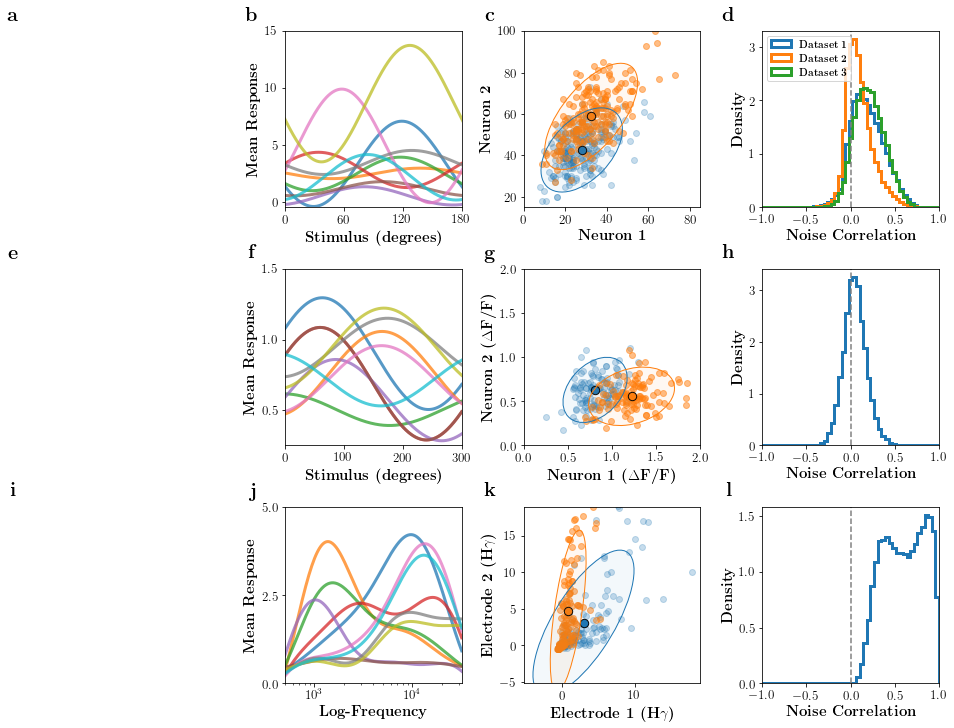

In [47]:
# Figure parameters
n_datasets = 3
n_cols = 4
ax_label_size = 15
ax_tick_size = 13
hist_linewidth = 3
mu_scatter_size = 70

# Create figure
fig, axes = plt.subplots(n_datasets, n_cols, figsize=(4 * n_cols, 4 * n_datasets))
plt.subplots_adjust(wspace=0.35, hspace=0.35)

# Leftmost plot: brain image, clear out space
for ax in axes[:, 0]:
    ax.axis(False)

"""
PVC11 Dataset
"""
# PVC11, Column 1: Tuning curves
pvc_tc_ax = axes[0, 1]
# Choose random tuning curves
rng_pvc11 = np.random.default_rng(43840912)
examples = rng_pvc11.integers(low=0, high=X_pvc11_1.shape[1], size=len(ccycle))
# Fit tuning curves using cosine basis functions
cos_bf = pvc11_1.get_design_matrix(form='cosine2')
ols = LinearRegression(fit_intercept=True).fit(cos_bf, X_pvc11_1)

for idx, example in enumerate(examples):
    angles, tc = pvc11_1.get_tuning_curve(
        form='cosine2',
        tuning_coefs=ols.coef_[example],
        intercept=ols.intercept_[example])

    pvc_tc_ax.plot(
        angles,
        tc,
        color=ccycle[idx],
        linewidth=3,
        alpha=0.75)

pvc_tc_ax.set_xlim([0, 180])
pvc_tc_ax.set_ylim([-0.5, 15])       
pvc_tc_ax.set_xticks([0, 60, 120, 180])
pvc_tc_ax.set_yticks([0, 5, 10, 15])
pvc_tc_ax.set_xlabel(r'\textbf{Stimulus (degrees)}', fontsize=ax_label_size)
pvc_tc_ax.set_ylabel(r'\textbf{Mean Response}', fontsize=ax_label_size)

# PVC11, Column 2: Example responses of two neurons
pvc_ex_ax = axes[0, 2]

stim1 = 0
stim2 = 30
neuron1 = 57
neuron2 = 34
X1 = X_pvc11_1[stimuli_pvc11 == stim1][:, [neuron1, neuron2]]
mu1 = np.mean(X1, axis=0)
X2 = X_pvc11_1[stimuli_pvc11 == stim2][:, [neuron1, neuron2]]
mu2 = np.mean(X2, axis=0)

pvc_ex_ax = plot_cov_ellipse(
    np.cov(X1, rowvar=False),
    mu=mu1,
    n_std=2.,
    facecolor=colors.hex_to_rgb(ccycle[0], 0.05),
    edgecolor=colors.hex_to_rgb(ccycle[0], 1.0),
    ax=pvc_ex_ax)
pvc_ex_ax = plot_cov_ellipse(
    np.cov(X2, rowvar=False),
    mu=mu2,
    n_std=2.,
    facecolor=colors.hex_to_rgb(ccycle[1], 0.05),
    edgecolor=colors.hex_to_rgb(ccycle[1], 1.0),
    ax=pvc_ex_ax)
pvc_ex_ax.scatter(
    X1[:, 0],
    X1[:, 1],
    color=ccycle[0],
    alpha=0.25)
pvc_ex_ax.scatter(
    X2[:, 0],
    X2[:, 1],
    color=ccycle[1],
    alpha=0.5)
pvc_ex_ax.scatter(
    mu1[0], mu1[1],
    color=ccycle[0],
    s=mu_scatter_size,
    edgecolor='black')
pvc_ex_ax.scatter(
    mu2[0], mu2[1],
    color=ccycle[1],
    s=mu_scatter_size,
    edgecolor='black')

pvc_ex_ax.set_xlim([0., 85])
pvc_ex_ax.set_ylim([15, 100])
pvc_ex_ax.set_xticks([0, 20, 40, 60, 80])
pvc_ex_ax.set_yticks([20, 40, 60, 80, 100])
pvc_ex_ax.set_xlabel(r'\textbf{Neuron 1}', fontsize=ax_label_size)
pvc_ex_ax.set_ylabel(r'\textbf{Neuron 2}', fontsize=ax_label_size)

# PVC11, Column 3: Distribution of noise correlations
pvc11_nc_ax = axes[0, 3]
# Calculate distribution of noise correlations
nc_pvc11_1 = analysis.all_correlations(X_pvc11_1, stimuli_pvc11)
nc_pvc11_2 = analysis.all_correlations(X_pvc11_2, stimuli_pvc11)
nc_pvc11_3 = analysis.all_correlations(X_pvc11_3, stimuli_pvc11)
# Plot distributions as density histograms
bins = np.linspace(-1, 1, 50)
pvc11_nc_ax.hist(
    nc_pvc11_1,
    bins=bins,
    density=True,
    color=ccycle[0],
    histtype='step',
    label=r'\textbf{Dataset 1}',
    linewidth=3)
pvc11_nc_ax.hist(
    nc_pvc11_2,
    bins=bins,
    density=True,
    color=ccycle[1],
    histtype='step',
    label=r'\textbf{Dataset 2}',
    linewidth=3)
pvc11_nc_ax.hist(
    nc_pvc11_3,
    bins=bins,
    density=True,
    color=ccycle[2],
    histtype='step',
    label=r'\textbf{Dataset 3}',
    linewidth=hist_linewidth)
pvc11_nc_ax.axvline(0, linestyle='--', color='grey')
pvc11_nc_ax.legend(loc=2)

pvc11_nc_ax.set_xlim([-1, 1])
pvc11_nc_ax.set_yticks([0, 1, 2, 3])
pvc11_nc_ax.set_xlabel(r'\textbf{Noise Correlation}', fontsize=ax_label_size)
pvc11_nc_ax.set_ylabel(r'\textbf{Density}', fontsize=ax_label_size)

"""
RET2 Dataset
"""
# RET2, Column 1: Tuning curves
ret_tc_ax = axes[1, 1]
# Choose random tuning curves
ret_rng = np.random.default_rng(2039191)
examples = ret_rng.integers(low=0, high=X_ret2.shape[1], size=len(ccycle))
# Fit tuning curves using cosine basis functions
cos_bf = ret2.get_design_matrix(form='cosine')
ols = LinearRegression(fit_intercept=True).fit(cos_bf, X_ret2)

for idx, example in enumerate(examples):
    angles, tc = ret2.get_tuning_curve(
        form='cosine',
        tuning_coefs=ols.coef_[example],
        intercept=ols.intercept_[example])

    ret_tc_ax.plot(
        angles,
        tc,
        color=ccycle[idx],
        linewidth=3,
        alpha=0.75)

ret_tc_ax.set_xlim([0, 300])
ret_tc_ax.set_ylim([.25, 1.5])       
ret_tc_ax.set_xticks([0, 100, 200, 300])
ret_tc_ax.set_yticks([0.5, 1.0, 1.5])
ret_tc_ax.set_xlabel(r'\textbf{Stimulus (degrees)}', fontsize=ax_label_size)
ret_tc_ax.set_ylabel(r'\textbf{Mean Response}', fontsize=ax_label_size)

# RET2, Column 2: Example responses
ret_ex_ax = axes[1, 2]

stim1 = 0
stim2 = 60
neuron1 = 32
neuron2 = 25
X1 = X_ret2[stimuli_ret2 == stim1][:, [neuron1, neuron2]]
mu1 = np.mean(X1, axis=0)
X2 = X_ret2[stimuli_ret2 == stim2][:, [neuron1, neuron2]]
mu2 = np.mean(X2, axis=0)

ret_ex_ax.scatter(
    X1[:, 0],
    X1[:, 1],
    color=ccycle[0],
    alpha=0.25)
plot_cov_ellipse(
    np.cov(X1, rowvar=False),
    mu=mu1,
    n_std=2.,
    facecolor=colors.hex_to_rgb(ccycle[0], 0.05),
    edgecolor=colors.hex_to_rgb(ccycle[0], 1.0),
    ax=ret_ex_ax)
plot_cov_ellipse(
    np.cov(X2, rowvar=False),
    mu=mu2,
    n_std=2.,
    facecolor=colors.hex_to_rgb(ccycle[1], 0.05),
    edgecolor=colors.hex_to_rgb(ccycle[1], 1.0),
    ax=ret_ex_ax)
ret_ex_ax.scatter(
    X2[:, 0],
    X2[:, 1],
    color=ccycle[1],
    alpha=0.5)
ret_ex_ax.scatter(
    mu1[0], mu1[1],
    color=ccycle[0],
    s=mu_scatter_size,
    edgecolor='black')
ret_ex_ax.scatter(
    mu2[0], mu2[1],
    color=ccycle[1],
    s=mu_scatter_size,
    edgecolor='black')

ret_ex_ax.set_xlim([0., 2])
ret_ex_ax.set_ylim(ret_ex_ax.get_xlim())
ret_ex_ax.set_xlabel(r'\textbf{Neuron 1 ($\Delta$F/F)}', fontsize=ax_label_size)
ret_ex_ax.set_ylabel(r'\textbf{Neuron 2 ($\Delta$F/F)}', fontsize=ax_label_size)

# RET2, Column 3: Noise correlation distribution
ret_nc_ax = axes[1, 3]
nc_ret2 = analysis.all_correlations(X_ret2, stimuli_ret2)
bins = np.linspace(-1, 1, 50)
ret_nc_ax.hist(
    nc_ret2,
    bins=bins,
    density=True,
    color=ccycle[0],
    histtype='step',
    linewidth=hist_linewidth)
ret_nc_ax.axvline(0, linestyle='--', color='grey')

ret_nc_ax.set_xlim([-1, 1])
ret_nc_ax.set_xlabel(r'\textbf{Noise Correlation}', fontsize=ax_label_size)
ret_nc_ax.set_ylabel(r'\textbf{Density}', fontsize=ax_label_size)

"""
ECOG Dataset
"""
# ECOG, Column 1: Tuning curves
ecog_tc_ax = axes[2, 1]
# Choose random tuning curves
rng_ecog = np.random.default_rng(45303)
examples = rng_ecog.integers(low=0, high=X_ecog.shape[1], size=len(ccycle))
# Fit tuning curves using Gaussian basis functions
gaussian_bf = ecog.get_design_matrix(form='bf')

for idx, example in enumerate(examples):
    lasso = LassoCV(fit_intercept=True).fit(gaussian_bf, X_ecog[:, example])

    frequencies, tc = ecog.get_tuning_curve(
        tuning_coefs=lasso.coef_,
        intercepts=lasso.intercept_)

    ecog_tc_ax.plot(
        frequencies,
        tc.ravel(),
        color=ccycle[idx],
        linewidth=3,
        alpha=0.75)

ecog_tc_ax.set_xscale('log')
ecog_tc_ax.set_xlim([500, 32000])
ecog_tc_ax.set_ylim([0., 5])       
ecog_tc_ax.set_xticks([1e3, 1e4])
ecog_tc_ax.set_yticks([0, 2.5, 5.])
ecog_tc_ax.set_xlabel(r'\textbf{Log-Frequency}', fontsize=ax_label_size)
ecog_tc_ax.set_ylabel(r'\textbf{Mean Response}', fontsize=ax_label_size)

# ECOG, Column 2: Example responses
ecog_ex_ax = axes[2, 2]

stim1 = 1024
stim2 = 2795
neuron1 = 13
neuron2 = 37
X1 = X_ecog[stimuli_ecog == stim1][:, [neuron1, neuron2]]
mu1 = np.mean(X1, axis=0)
X2 = X_ecog[stimuli_ecog == stim2][:, [neuron1, neuron2]]
mu2 = np.mean(X2, axis=0)

ecog_ex_ax.scatter(
    X1[:, 0],
    X1[:, 1],
    color=ccycle[0],
    alpha=0.25)
plot_cov_ellipse(
    np.cov(X1, rowvar=False),
    mu=mu1,
    n_std=2.,
    facecolor=colors.hex_to_rgb(ccycle[0], 0.05),
    edgecolor=colors.hex_to_rgb(ccycle[0], 1.0),
    ax=ecog_ex_ax)
plot_cov_ellipse(
    np.cov(X2, rowvar=False),
    mu=mu2,
    n_std=2.,
    facecolor=colors.hex_to_rgb(ccycle[1], 0.05),
    edgecolor=colors.hex_to_rgb(ccycle[1], 1.0),
    ax=ecog_ex_ax)
ecog_ex_ax.scatter(
    X2[:, 0],
    X2[:, 1],
    color=ccycle[1],
    alpha=0.5)
ecog_ex_ax.scatter(
    mu1[0], mu1[1],
    color=ccycle[0],
    s=mu_scatter_size,
    edgecolor='black')
ecog_ex_ax.scatter(
    mu2[0], mu2[1],
    color=ccycle[1],
    s=mu_scatter_size,
    edgecolor='black')

#ecog_ex_ax.set_xlim([0., 2])
ecog_ex_ax.set_ylim(ecog_ex_ax.get_xlim())
ecog_ex_ax.set_xlabel(r'\textbf{Electrode 1 (H$\gamma$)}', fontsize=ax_label_size)
ecog_ex_ax.set_ylabel(r'\textbf{Electrode 2 (H$\gamma$)}', fontsize=ax_label_size)

# ECOG, Column 3: Noise correlation distribution
ecog_nc_ax = axes[2, 3]
nc_ecog = analysis.all_correlations(X_ecog, stimuli_ecog)
bins = np.linspace(-1, 1, 50)
ecog_nc_ax.hist(
    nc_ecog,
    bins=bins,
    density=True,
    color=ccycle[0],
    histtype='step',
    linewidth=hist_linewidth)
ecog_nc_ax.axvline(0, linestyle='--', color='grey')

ecog_nc_ax.set_xlim([-1, 1])
ecog_nc_ax.set_xlabel(r'\textbf{Noise Correlation}', fontsize=ax_label_size)
ecog_nc_ax.set_ylabel(r'\textbf{Density}', fontsize=ax_label_size)
"""
Global Settings
"""
# Set axis tick label size
for ax in axes.ravel():
    ax.tick_params(labelsize=ax_tick_size)
    
subplot_labels = [r'\textbf{a}', r'\textbf{b}', r'\textbf{c}', r'\textbf{d}',
                  r'\textbf{e}', r'\textbf{f}', r'\textbf{g}', r'\textbf{h}',
                  r'\textbf{i}', r'\textbf{j}', r'\textbf{k}', r'\textbf{l}']
for ax, label in zip(axes.ravel(), subplot_labels):
    ax.text(x=-0.19,
            y=1.09,
            s=label,
            ha='center',
            va='center',
            size=20,
            fontfamily='sans-serif',
            transform=ax.transAxes)
    
plt.show()